In [18]:
%matplotlib inline
import matplotlib


In [19]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg


In [20]:
#load data
print "loading data"
#iterate over directory and get all png images\n
imageset = np.zeros((7704,64,64,3))

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chsarath/kaushal_project/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = scipy.misc.imread(filepath)
            
print 'loading done'

loading data
loading done


(64, 64, 3)


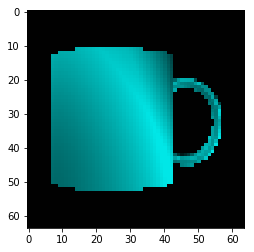

In [21]:
#this part is to visulize image
tmp = imageset[6920][...,::-1]
print tmp.shape
plt.imshow(tmp)
plt.show()

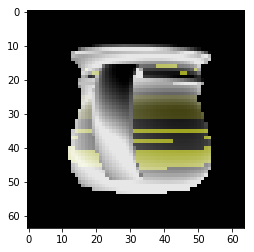

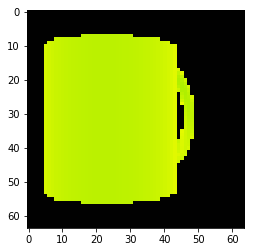

In [22]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 46 folders would be used for testing

data_train = np.array(imageset[:6120])
data_test = np.array(imageset[6120:])


#This code will generate labels for the dataset

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image

train_labels = np.zeros(data_train.shape)
test_labels = np.zeros(data_test.shape)

for cnt in range(170):
    train_labels[cnt*36:(cnt+1)*36] = np.roll(data_train[cnt*36:(cnt+1)*36], 1, axis=0)

for cnt in range(46):
    test_labels[cnt*36:(cnt+1)*36] = np.roll(data_test[cnt*36:(cnt+1)*36], 1, axis=0)


#tmp = data_test[600]
tmp = data_train[35]
tmp1 = test_labels[555][...,::-1]


plt.imshow(tmp)
plt.show()
plt.imshow(tmp1)
plt.show()


In [23]:
#normalize data


mean_image = np.mean(data_train, axis=0)
max_image = np.amax(data_train, axis=0)

data_train -= mean_image
data_train /= max_image

data_test -= mean_image
data_test /= max_image


mean_labels = np.mean(train_labels, axis=0)
max_labels = np.amax(train_labels, axis=0)

train_labels -= mean_labels
train_labels /= max_labels

test_labels -= mean_labels
test_labels /= max_labels

tmp = np.array(data_test[800])
#tmp1 = train_labels[35]

# tmp *= max_labels
# tmp += mean_labels

# plt.imshow(tmp)
# plt.show()


In [28]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [29]:
#defination of my layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
#     print type(input_dim)
#     print input_dim
    print batch_size
    print w
    print num_filter
    print type(num_filter)
    print type(w)
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    

    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)

In [30]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

inputs_ = tf.placeholder(tf.float32, (72, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (72, 64,64,3), name="target")

In [31]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Max pool + Conv + relu  + Max pool + Conv + relu  + Max pool
# After 3 Convolution ,we will have a latent space

with tf.variable_scope('conv1'):
    conv1 = conv2d(inputs_, 3, 2, 16)
    tanh1 = tf.nn.relu(conv1)
    #pool1 = max_pool(tanh1, 3, 2)

# Size of pool1 would be 32*32*32

with tf.variable_scope('conv2'):
    conv2 = conv2d(tanh1, 3, 2, 32)
    tanh2 = tf.nn.relu(conv2)
    #pool2 = max_pool(tanh2, 3, 2)

# # Size of pool2 would be 16*16*16

with tf.variable_scope('conv3'):
    conv3 = conv2d(tanh2, 3, 2, 64)
    tanh3 = tf.nn.relu(conv3)
    #pool3 = max_pool(tanh3, 3, 2)

# # Latent space is 8*8*8
# print pool3.get_shape().as_list()
# #Building the decoder

with tf.variable_scope('deconv1'):
    deconv1 = deconv2d(tanh3, 3, 2, 32)
    tanh4 = tf.nn.relu(deconv1)

print tanh4.get_shape().as_list()
with tf.variable_scope('deconv2'):
    deconv2 = deconv2d(tanh4, 3, 2, 16)
    tanh5 = tf.nn.relu(deconv2)
print tanh5.get_shape().as_list()

with tf.variable_scope('deconv3'):
    deconv3 = deconv2d(tanh5, 3, 2, 3)
    tanh6 = tf.nn.tanh(deconv3)

print tanh6.get_shape().as_list()


72
8
32
<type 'int'>
<type 'int'>
[72, 16, 16, 32]
72
16
16
<type 'int'>
<type 'int'>
[72, 32, 32, 16]
72
32
3
<type 'int'>
<type 'int'>
[72, 64, 64, 3]


In [32]:

#calculate loss
loss_op = tf.reduce_mean(abs(tanh6 - targets_))

#Optimizer
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)



In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training Parameters

epochs = 5
batch_size = 72
total_images = 6120

display_step = 1000
examples_to_show = 10


for e in range(epochs):
    for ii in range(total_images // batch_size):
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        feed_dict = {inputs_: batch, targets_: batch_labels}

        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=feed_dict)
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(loss))


('Epoch: 1/5...', 'Training loss: 0.1582')
('Epoch: 1/5...', 'Training loss: 0.1609')
('Epoch: 1/5...', 'Training loss: 0.1806')
('Epoch: 1/5...', 'Training loss: 0.1478')
('Epoch: 1/5...', 'Training loss: 0.1469')
('Epoch: 1/5...', 'Training loss: 0.1956')
('Epoch: 1/5...', 'Training loss: 0.2058')
('Epoch: 1/5...', 'Training loss: 0.1888')
('Epoch: 1/5...', 'Training loss: 0.2336')
('Epoch: 1/5...', 'Training loss: 0.1919')
('Epoch: 1/5...', 'Training loss: 0.1727')
('Epoch: 1/5...', 'Training loss: 0.1704')
('Epoch: 1/5...', 'Training loss: 0.2076')
('Epoch: 1/5...', 'Training loss: 0.1756')
('Epoch: 1/5...', 'Training loss: 0.2375')
('Epoch: 1/5...', 'Training loss: 0.2179')
('Epoch: 1/5...', 'Training loss: 0.1583')
('Epoch: 1/5...', 'Training loss: 0.1854')
('Epoch: 1/5...', 'Training loss: 0.1918')
('Epoch: 1/5...', 'Training loss: 0.1960')
('Epoch: 1/5...', 'Training loss: 0.1815')
('Epoch: 1/5...', 'Training loss: 0.1766')
('Epoch: 1/5...', 'Training loss: 0.1537')
('Epoch: 1/

(64, 64, 3)


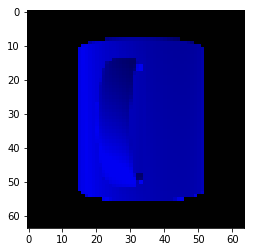

In [34]:

#compare test image 

tmp = imageset[6120+71]
print tmp.shape
plt.imshow(tmp)
plt.show()


In [35]:


feed_dict = {inputs_: data_test[0:72], targets_: test_labels[0:72]}

fetches = [tanh6, loss_op]
out, loss = sess.run(fetches, feed_dict=feed_dict)
print loss

0.105179


In [36]:
other = np.array(out)

print other.shape

(72, 64, 64, 3)


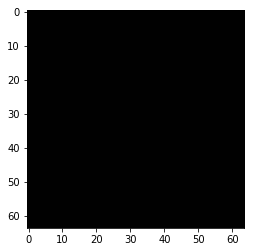

In [189]:
# test_labels_copy = test_labels[0:72]

# test_labels_copy *= max_labels
# test_labels_copy += mean_labels

# tmp = test_labels_copy[36]

# tmp = np.where(tmp>255,255,tmp)
# tmp = np.where(tmp<0,0,tmp)
# tmp = tmp[...,::-1]
# plt.imshow(tmp)
# plt.show()

In [276]:
out = 1 / (1 + np.exp(-other))

<type 'numpy.ndarray'>
(72, 64, 64, 3)
(64, 64, 3)
255.0
71.3630718954
255.0
0.0
(64, 64, 3)


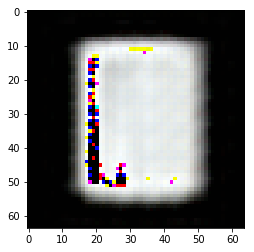

In [37]:

out *= max_labels
out += mean_labels

print type(tmp)
tmp = out[0][...,::-1]
print out.shape
print max_labels.shape
print np.amax(mean_labels)
print np.amin(mean_labels)
out = np.around(out)
out = np.where(out>255,255,out)
out = np.where(out<0,0,out)

#mmax = np.max(out)
#mmin = np.min(out)

#out = (out - mmin) / (mmax - mmin)
#out *= 255
#out = np.around(out)

print np.amax(out)
print np.amin(out)
tmp = out[71]
print tmp.shape
plt.imshow(tmp)
plt.show()


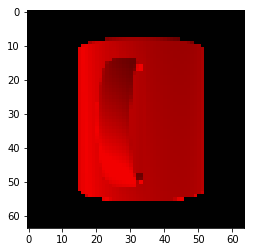

In [170]:
test_labels *= max_labels
test_labels += mean_labels

tmp = test_labels[36]

tmp = np.where(tmp>255,255,tmp)
tmp = np.where(tmp<0,0,tmp)
tmp = tmp[...,::-1]
plt.imshow(tmp)
plt.show()